## Collection of data from WHO sources on relevant maternal health indicators

This notebook highlights an example of future work that could collate similiar data to that on Bangladesh, but for all countries. Note all sources are downloaded from the WHO website, which is publicly available via the following links:

NMR: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/neonatal-mortality-rate-(per-1000-live-births)

Caesarean Sections: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/births-by-caesarean-section-(-)

Antenatal Care Visits: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/antenatal-care-coverage-at-least-four-visits

Hospital density: https://www.who.int/data/gho/data/indicators/indicator-details/GHO/total-density-per-100-000-population-hospitals

Tetanus Toxoid Vaccination Coverage: https://immunizationdata.who.int/pages/coverage/tt2plus.html?GROUP=Countries&ANTIGEN=TT2PLUS&YEAR=&CODE=

In [11]:
import pandas as pd
import numpy as np

In [5]:
#Function for reading csv into dataframe

def get_csv(x):
    y = pd.read_csv(x,index_col = 0)
    return(y)

In [6]:
#Load in Neonatal Mortality Rate global data
nmr_df = get_csv(r"C:\Users\wtaylor\Downloads\NMR_global.csv")

#Load in Caesarian Section global data
csec_df = get_csv(r"C:\Users\wtaylor\Downloads\caesarean_section_global.csv")
               
#Load in Antenatal Care (4 visits+) data
anc_df = get_csv(r"C:\Users\wtaylor\Downloads\ANC_4_global.csv")

#Load in Hospital Denisty data
hosp_df = get_csv(r"C:\Users\wtaylor\Downloads\hospital_density_global.csv")

#Load in Tetanus Vaccine global data. Note use xlsl but changed to csv to make it easier for data management 
tvac_df = pd.read_excel(r"C:\Users\wtaylor\Downloads\Protection at birth (PAB) against neonatal tetanus and Tetanus toxoid-containing vaccine (TT2+_Td2+) vaccination coverage.xlsx")

In [7]:
#First need to ensure data only contains NMR values for both sexes
nmr_df = nmr_df.loc[(nmr_df['Indicator'] == 'Neonatal mortality rate (per 1000 live births)') & (nmr_df['Dim1'] == 'Both sexes')]

#Obtain NMR values and their respective country
nmr = nmr_df[['Location', 'Period','FactValueNumeric']]

#We only want data from 2000-2019
nmr = nmr.loc[(nmr['Period'] >= 2000) & (nmr['Period'] <= 2019)]

#Change names of columns to make them more understandable for reader
nmr = nmr.rename({'Period': 'Year', 'FactValueNumeric': 'NMR'}, axis=1)

In [8]:
#Obtain caesarian section values and their respective country
csec = csec_df[['Location', 'Period','FactValueNumeric']]

#Change names of columns to make them more understandable for reader
csec = csec.rename({'Period': 'Year', 'FactValueNumeric': 'Percentage of C-sections'}, axis=1)

#Now get average C-section for each region
csec = csec.groupby('Location').mean().reset_index()

In [9]:
#Obtain caesarian section values and their respective country
anc = anc_df[['Location', 'Period','FactValueNumeric']]

#Change names of columns to make them more understandable for reader
anc = anc.rename({'Period': 'Year', 'FactValueNumeric': 'Percentage of >4 ANC visits'}, axis=1)

##Now get average of ANC for each region
anc = anc.groupby('Location').mean().reset_index()

In [12]:
#First need to ensure Official Coverage is recorded
tvac_df = tvac_df.loc[tvac_df['COVERAGE_CATEGORY'] == 'OFFICIAL']

#Obtain vaccination coverages and their respective country
tvac = tvac_df[['NAME', 'YEAR','COVERAGE']]

#Change names of columns to make them more understandable for reader
tvac = tvac.rename({'NAME': 'Location','YEAR': 'Year', 'COVERAGE': 'Vaccination Coverage'}, axis=1)

#Ensure only data from 2000-2019 is present
tvac = tvac.loc[(tvac['Year'] >= 2000) & (tvac['Year'] <= 2019)]


#Now do sense check of data. Importantly, max vaccination coverage goes above 100 so will need to clean this up. 
for value in tvac['Vaccination Coverage']:
    if value > 100.0:
        tvac['Vaccination Coverage']=tvac['Vaccination Coverage'].replace(value, np.nan)

#Now drop rows which contain empty values
tvac = tvac[tvac['Vaccination Coverage'].notna()]   

In [13]:
#Obtain hospital denisty for each region
hosp_no = hosp_df[['Location','Value']]

#Change names of columns to make them more understandable for reader
hosp_no = hosp_no.rename({'Value': 'Hospital Density/100,000'}, axis=1)

#Get average of hospital density for each regiion
hosp_no = hosp_no.groupby('Location').mean().reset_index()

In [14]:
##Now merge datasets into one

new_df = pd.merge(tvac, nmr, left_on=['Location', 'Year'], right_on = ['Location', 'Year'],how='left')

##Merge on C-section data
new_df2 = pd.merge(new_df,csec[['Percentage of C-sections','Location']],on='Location', how='left')

#Now merge on ANC
new_df3 = pd.merge(new_df2,anc[['Percentage of >4 ANC visits','Location']],on='Location', how='left')

#Now merge on hospital density
new_df4 = pd.merge(new_df3,hosp_no[['Hospital Density/100,000','Location']],on = 'Location', how = 'left')

In [15]:
###Fill empty values with means

new_df4['Percentage of C-sections'] = new_df4['Percentage of C-sections'].fillna(new_df4.groupby('Location')['Percentage of C-sections'].transform('mean'))
new_df4['Percentage of >4 ANC visits'] = new_df4['Percentage of >4 ANC visits'].fillna(new_df4.groupby('Location')['Percentage of >4 ANC visits'].transform('mean'))
new_df4['NMR'] = new_df4['NMR'].fillna(new_df4.groupby('Location')['NMR'].transform('mean'))
new_df4['Hospital Density/100,000'] = new_df4['Hospital Density/100,000'].fillna(new_df4.groupby('Location')['Hospital Density/100,000'].transform('mean'))

In [16]:
##Now drop rows which still have remaining empty values. This may happen because not all databases had the same number of countries and therefore some columns will have missing data still
new_df4.dropna(subset=['NMR','Percentage of C-sections','Percentage of >4 ANC visits','Hospital Density/100,000'], inplace=True)

Now we have a similiar dataset to the one had been webscraped from the Bangladesh Public Health Bulletins. Although this dataset has fewer health indicators, the dataset is a lot larger.

In [17]:
new_df4.describe()

,Year,Vaccination Coverage,NMR,Percentage of C-sections,Percentage of >4 ANC visits,"Hospital Density/100,000"
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,2009.725474,66.080495,23.862968,15.007131,61.245257,2.208545
std,5.733463,24.078557,11.935757,13.508374,21.647323,7.024349
min,2000.000000,0.000000,1.350000,1.400000,16.900000,0.000000
25%,2005.000000,50.000000,13.210000,4.500000,45.583333,0.410000
50%,2010.000000,69.000000,24.110000,9.300000,64.016667,0.700000
75%,2015.000000,86.000000,32.420000,26.700000,77.077778,1.810000
max,2019.000000,100.000000,60.630000,51.800000,99.800000,56.450000


Let's inspect the Bangladesh data. Note that values for 'Percentage of C-sections', 'Percentage of >4 ANC visits' and 'Hospital Density/100,000' are constant for every year owing to the fact the WHO datasets has limited data. 

In [18]:
new_df4.loc[new_df4['Location'] == 'Bangladesh']

,Location,Year,Vaccination Coverage,NMR,Percentage of C-sections,Percentage of >4 ANC visits,"Hospital Density/100,000"
106,Bangladesh,2019,94.0,19.06,30.7,22.776923,0.17
107,Bangladesh,2018,97.0,19.83,30.7,22.776923,0.17
108,Bangladesh,2017,97.0,20.66,30.7,22.776923,0.17
109,Bangladesh,2016,96.3,21.56,30.7,22.776923,0.17
110,Bangladesh,2015,98.0,22.51,30.7,22.776923,0.17
111,Bangladesh,2014,97.5,23.52,30.7,22.776923,0.17
112,Bangladesh,2013,96.3,24.61,30.7,22.776923,0.17
113,Bangladesh,2012,96.0,25.76,30.7,22.776923,0.17
114,Bangladesh,2011,96.0,26.99,30.7,22.776923,0.17
115,Bangladesh,2010,95.0,28.28,30.7,22.776923,0.17


## Principal Component Analysis of the global data

Below shows the code used to conduct a PCA on the global data loaded in from WHO sources.

In [91]:
#Make a copy of the dataframe to avoid overwriting it
new_df5 = new_df4.copy()

#Reset index to replace locations with numbers as locations are no longer needed
new_df5 = new_df5.reset_index(drop=True)


In [92]:
#Locate NMR values 
nmr_mag = new_df5.values[:,2]

#Replace NMR values <5 with 0
nmr_mag = np.where(nmr_mag <= 5, 0, nmr_mag)
#Replace NMR values >5 and <10 with 1
nmr_mag = np.where(((nmr_mag > 5) & (nmr_mag <= 10)), 1, nmr_mag)
#Replace NMR values >10 and <15 with 2
nmr_mag = np.where(((nmr_mag > 10) & (nmr_mag <= 15)), 2, nmr_mag)
#Replace NMR values >15 and <20 with 3
nmr_mag = np.where(((nmr_mag > 15) & (nmr_mag <= 20)), 3, nmr_mag)
#Replace NMR values >20 with 4
nmr_mag = np.where(nmr_mag >= 20, 4, nmr_mag)

#Now add this to existing dataframe
nmr_score_df = pd.DataFrame(nmr_mag)

new_df5 = new_df5.join(nmr_score_df)

In [93]:
#Now amend new_df5 so that it only contains NMR score 0-4
new_df5 = new_df5.drop(['NMR'],axis = 1)
new_df5['NMR_score'] = new_df5[[0]]
new_df5 = new_df5.drop([0], axis = 1)

In [94]:
#Replace values of 0-4 with ranges
new_df5['NMR_score'] = new_df5['NMR_score'].replace(0,'<5 NMR')
new_df5['NMR_score'] = new_df5['NMR_score'].replace(1,'5-10 NMR')
new_df5['NMR_score'] = new_df5['NMR_score'].replace(2,'10-15 NMR')
new_df5['NMR_score'] = new_df5['NMR_score'].replace(3,'15-20 NMR')
new_df5['NMR_score'] = new_df5['NMR_score'].replace(4,'>20 NMR')

#Inspect dataframe
new_df5

,Location,Year,Vaccination Coverage,Percentage of C-sections,Percentage of >4 ANC visits,"Hospital Density/100,000",NMR_score
0,Afghanistan,2019,85.0,2.7,16.9000,0.37,>20 NMR
1,Afghanistan,2018,85.0,2.7,16.9000,0.37,>20 NMR
2,Afghanistan,2017,86.0,2.7,16.9000,0.37,>20 NMR
3,Afghanistan,2016,58.0,2.7,16.9000,0.37,>20 NMR
4,Afghanistan,2015,91.0,2.7,16.9000,0.37,>20 NMR
...,...,...,...,...,...,...,...
1208,Zimbabwe,2004,70.0,5.8,68.5375,0.52,>20 NMR
1209,Zimbabwe,2003,60.0,5.8,68.5375,0.52,>20 NMR
1210,Zimbabwe,2002,60.0,5.8,68.5375,0.52,>20 NMR
1211,Zimbabwe,2001,60.0,5.8,68.5375,0.52,>20 NMR


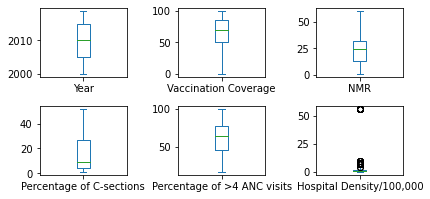

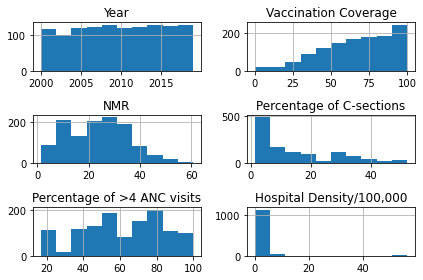

In [98]:
#Boxplots
new_df4.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

#Histograms
new_df4.hist()
plt.tight_layout()
plt.show()

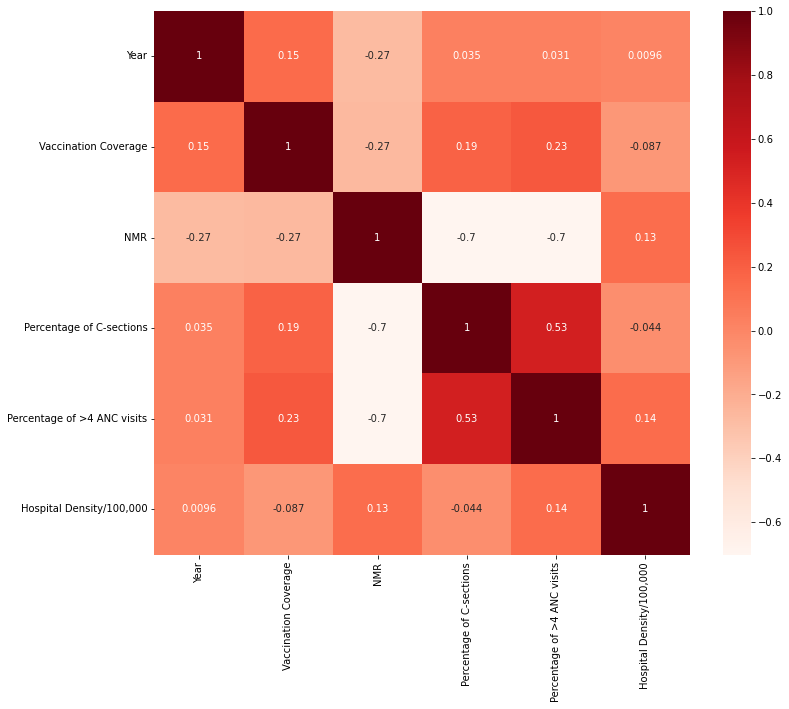

In [97]:
plt.figure(figsize=(12,10))
cor = new_df4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Now let's conduct a PCA to see how it differs from that of just the Bangladesh data

In [103]:
features = ['Vaccination Coverage', 'Percentage of C-sections','Percentage of >4 ANC visits',  'Hospital Density/100,000']

# Separating out the features
x = new_df5.loc[:, features].values

# Separating out the target
y = new_df5.loc[:,['NMR_score']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [104]:
##Check data has been normalised. Should have mean as close to 0 and sd as close to 1, as possible
print(x.shape)

np.mean(x),np.std(x)

(1213, 4)


(-1.6474867636647004e-16, 1.0)

In [105]:
pca = PCA()
principalComponents = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principalComponents, columns = ['pc_1', 'pc_2', 'pc_3','pc_4'])

In [110]:
final_df = pd.concat([principal_df, new_df5[['NMR_score']]], axis = 1)
final_df

,pc_1,pc_2,pc_3,pc_4,NMR_score
0,1.623559,-0.976726,1.148996,0.898345,>20 NMR
1,1.623559,-0.976726,1.148996,0.898345,>20 NMR
2,1.606884,-0.993915,1.182604,0.903161,>20 NMR
3,2.073776,-0.512609,0.241578,0.768304,>20 NMR
4,1.523511,-1.079863,1.350645,0.927243,>20 NMR
...,...,...,...,...,...
1208,0.156879,-0.194324,0.283138,-0.721338,>20 NMR
1209,0.323626,-0.022429,-0.052943,-0.769501,>20 NMR
1210,0.323626,-0.022429,-0.052943,-0.769501,>20 NMR
1211,0.323626,-0.022429,-0.052943,-0.769501,>20 NMR


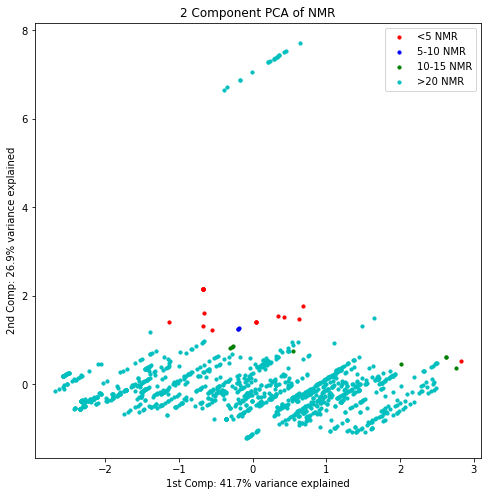

In [112]:
##First PCA for first two components
fig = plt.figure(figsize = (8,8))

var_expl = pca.explained_variance_ratio_

targets = ['<5 NMR', '5-10 NMR','10-15 NMR','>20 NMR']
colors = ['r', 'b', 'g','c']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['NMR_score'] == target
    plt.scatter(final_df.loc[indicesToKeep, 'pc_1']
               , final_df.loc[indicesToKeep, 'pc_2']
               , c = color
               , s = 10)

plt.title("2 Component PCA of NMR")
plt.legend(targets,loc=1, shadow=False)    
plt.xlabel('1st Comp: ' + str(round(var_expl[0]*100,1)) + '% variance explained')
plt.ylabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')    
plt.show()

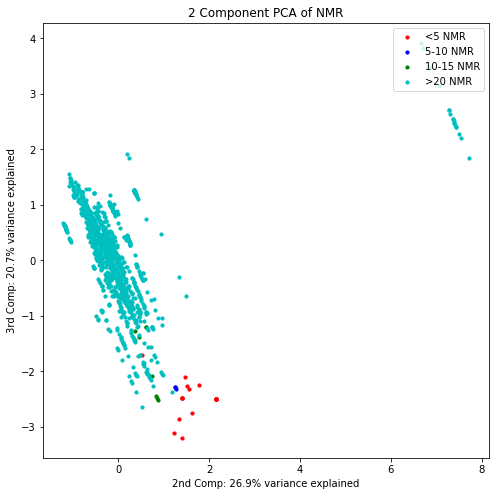

In [113]:
##PCA of components 2 and 3
fig = plt.figure(figsize = (8,8))

var_expl = pca.explained_variance_ratio_

targets = ['<5 NMR', '5-10 NMR','10-15 NMR','>20 NMR']
colors = ['r', 'b', 'g','c']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['NMR_score'] == target
    plt.scatter(final_df.loc[indicesToKeep, 'pc_2']
               , final_df.loc[indicesToKeep, 'pc_3']
               , c = color
               , s = 10)

plt.title("2 Component PCA of NMR")
plt.legend(targets,loc=1, shadow=False)    
plt.xlabel('2nd Comp: ' + str(round(var_expl[1]*100,1)) + '% variance explained')
plt.ylabel('3rd Comp: ' + str(round(var_expl[2]*100,1)) + '% variance explained')    
plt.show()

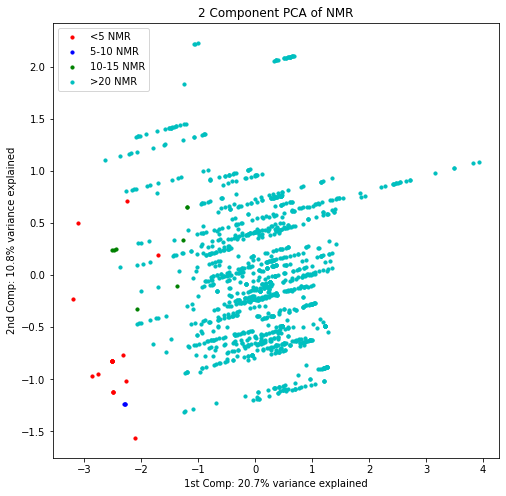

In [114]:
##PCA of components 3 and 4
fig = plt.figure(figsize = (8,8))

var_expl = pca.explained_variance_ratio_

targets = ['<5 NMR', '5-10 NMR','10-15 NMR','>20 NMR']
colors = ['r', 'b', 'g','c']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['NMR_score'] == target
    plt.scatter(final_df.loc[indicesToKeep, 'pc_3']
               , final_df.loc[indicesToKeep, 'pc_4']
               , c = color
               , s = 10)

plt.title("2 Component PCA of NMR")
plt.legend(targets,loc=2, shadow=False)    
plt.xlabel('1st Comp: ' + str(round(var_expl[2]*100,1)) + '% variance explained')
plt.ylabel('2nd Comp: ' + str(round(var_expl[3]*100,1)) + '% variance explained')    
plt.show()